# Variables importances

In [11]:
import pandas as pd
import shap
import datetime
import importlib
import json
import os
import gc
import click
import re
import pickle
import time
import lightgbm as lgbm
import numpy as np
import sys

sys.path.append("../src")

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from collections import OrderedDict

from run_eval import run_cross_validation
from dataset import filter_dataset, load_dataset, sample_dataset
from make_dataset import make_dataset, create_output_path
from train_model import train_model, pprint_json
from models.utils import log_target_transform
from config.lgbm_final import to_codes

from preprocessing.feature_engineering import (AddSimpleFeatures, GeoKNN,
                                               GroupByImputer, MaxCap,
                                               PrevPrice, SelectColumns,
                                               UnitConverter)

shap.initjs()

In [2]:
_numerical_features = ['ANNEE_CONST', 'SUPERFICIE', 'CODE_UTILISATION', 'IMMEUBLE_DANS_EVIA',
                        'NB_LOGEMENTS', 'N_COMMERCES','N_ETAGES', 'LOT_SUPERFICIE',
                       'CUR_EVAL_VALEUR_BATISSE', 'CUR_EVAL_VALEUR_LOT',
                       'FIRST_PREV_EVAL_VALEUR_BATISSE', 'FIRST_PREV_EVAL_VALEUR_LOT',
                        'LONGITUDE_FRESH', 'LATTITUDE_FRESH',
                        'PREC_PRICE', 'PREC_DELTA_DATE',
                        'PREC_LIE', 'PREC_TRANSMISSION', 'PREC_REPRISE', 'PREC_GARANTIE',
                        'PREC_NOUVELLE_CONSTRUCTION', 'CONSTRUCTION_NEUVE',
                        'VENTE_MULTIPLE', 'VENTE_LIE']

_categorical_features = OrderedDict([
    ('CATEGORIE_BATIMENT', 10),
    ('VILLE', 10),
    ('ARRONDISSEMENT_NOM', 10)
])

_num_feats_eng = ['TX_YEAR', 'CUR_DATE_EVAL_YEAR']

_knn_cols = ['SUPERFICIE', 'LOT_SUPERFICIE', 'ANNEE_CONST',
             'N_ETAGES', 'NB_LOGEMENTS',
             'FIRST_PREV_EVAL_VALEUR_BATISSE', 'FIRST_PREV_EVAL_VALEUR_LOT',
             'CUR_EVAL_VALEUR_BATISSE', 'CUR_EVAL_VALEUR_LOT']

In [3]:
model_name = 'lgbm_final'
sampling_prop = 0.05

In [5]:
connection_train = ['jlr_website', '1qaz2wsx', 'azuorap3']
df = make_dataset('input_train',connection_train, sampling_prop)

Preprocess dataset...
Modification of dtypes...
converting: DATE_TX
DataFrame returned...


In [6]:
df = df.query('MONTANT > 100000')

In [7]:
kw_args={'cols_to_convert': ['LOT_SUPERFICIE'],
                 'unit_col': ['UNITE_AIRE'],
                 'unit': 'PI2'}
df = UnitConverter(df, **kw_args)

In [8]:
X = df.drop('MONTANT', axis = 1)
y = df['MONTANT']
print(y.shape)
print(X.shape)

(67507,)
(67507, 56)


In [9]:
max_cap  = MaxCap(cols_to_cap=['LOT_SUPERFICIE'], max_cap=10000)
max_cap.fit(X)
X = max_cap.transform(X)

In [12]:
select = SelectColumns(columns = _categorical_features)
select.fit(X)
catcol = select.transform(X)
catcol = to_codes(catcol)

add = AddSimpleFeatures()
add.fit(X)
added_features = add.transform(X)

select = SelectColumns(columns = _numerical_features + _num_feats_eng)
select.fit(X)
numcol = select.transform(X)

X = pd.concat([catcol, numcol], axis=1, join_axes=[catcol.index])

../src\preprocessing\feature_engineering.py:95: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return x.loc[:, self.columns]
C:\Users\charlesd\AppData\Local\conda\conda\envs\ev2\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [13]:
print(numcol.shape)
print(catcol.shape)
print(X.shape)

(67507, 26)
(67507, 3)
(67507, 29)


In [14]:
#X = preprocess.fit_transform(X, y)
y = np.log(y)

In [15]:
_regressor = LGBMRegressor(objective='regression',
                           num_leaves=63,
                           learning_rate=0.1,
                           n_estimators=700,
                           min_data_per_leaf = 5,
                           fraction_feature = 0.8,
                           max_depth = -1,
                           silent=False,
                           random_state=1234, n_jobs=-1)
model = _regressor.fit(X, y)

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [17]:
shap.summary_plot(shap_values, X)

C:\Users\charlesd\AppData\Local\conda\conda\envs\ev2\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [18]:
X.columns[12]

'CUR_EVAL_VALEUR_LOT'

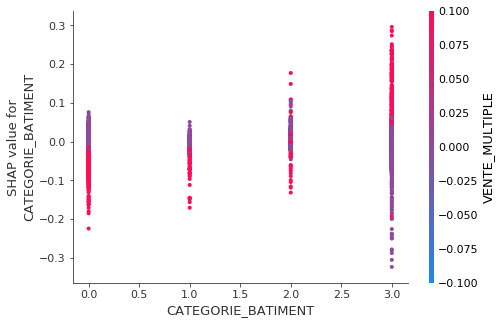

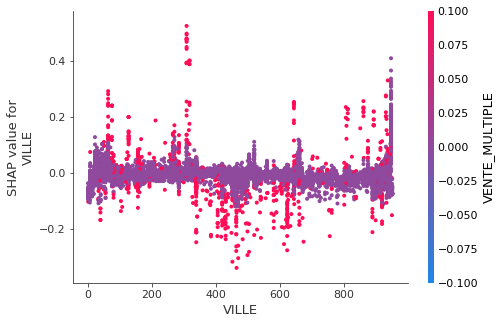

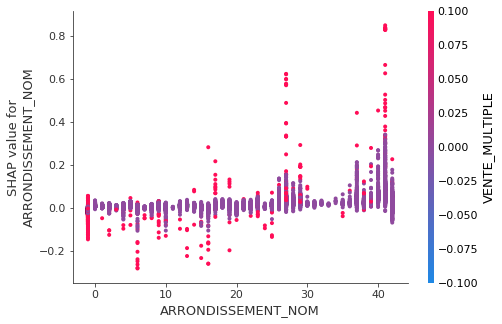

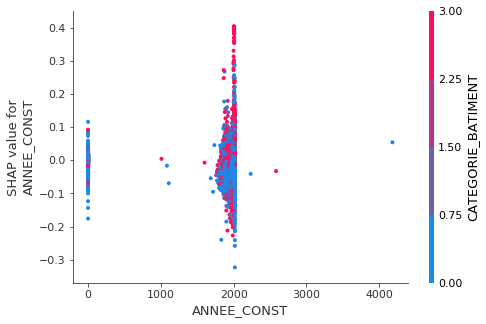

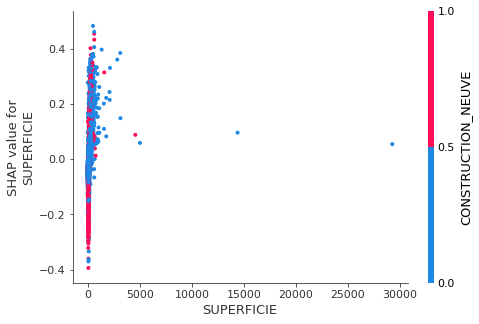

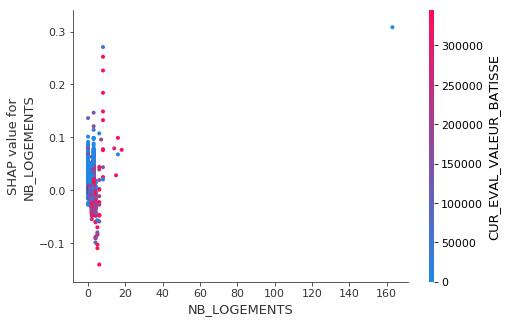

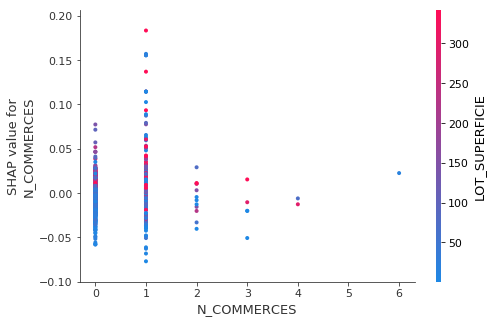

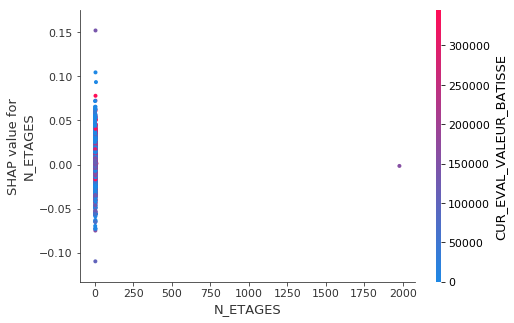

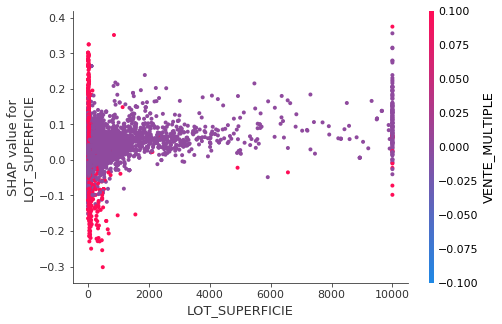

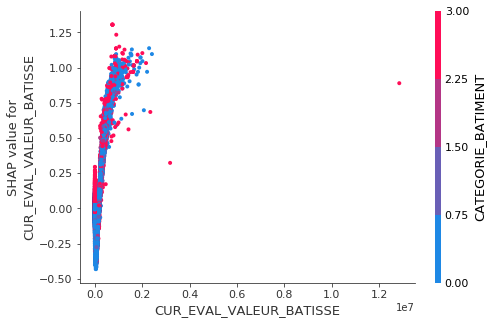

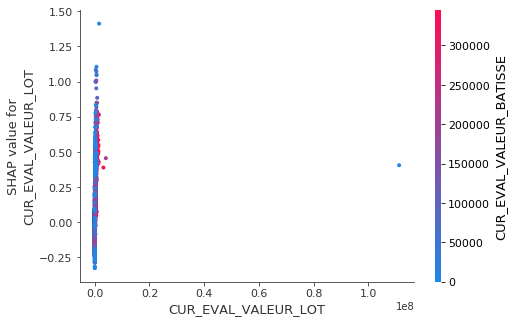

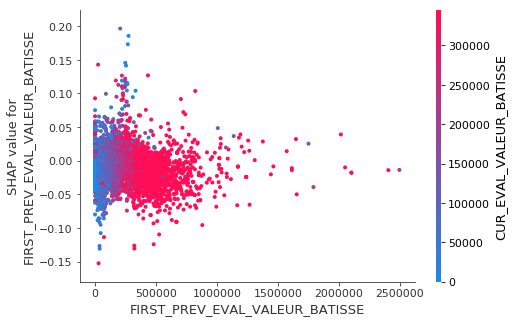

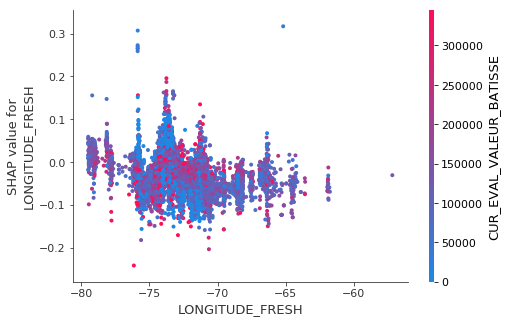

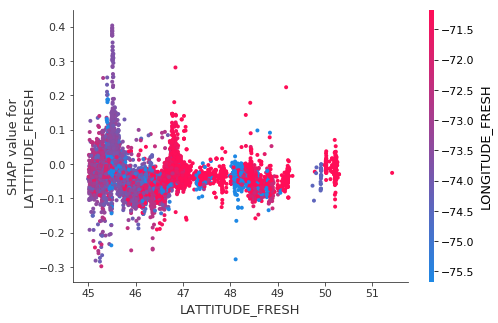

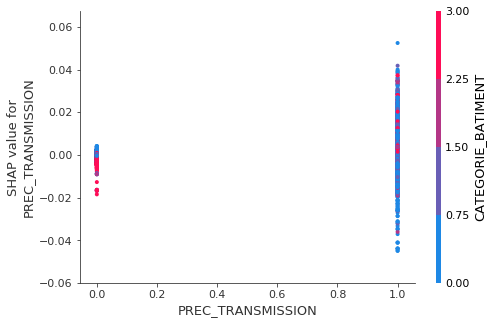

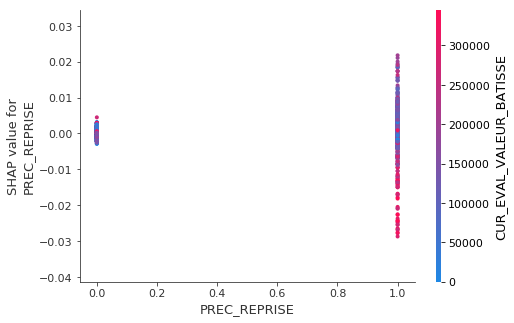

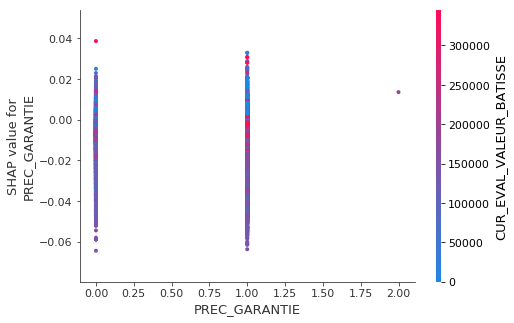

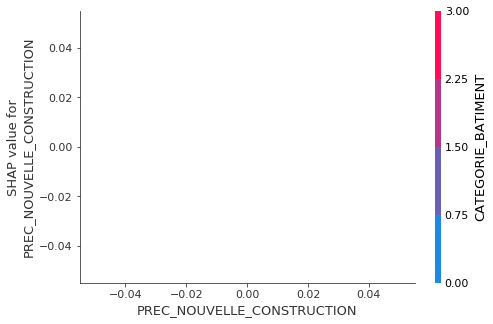

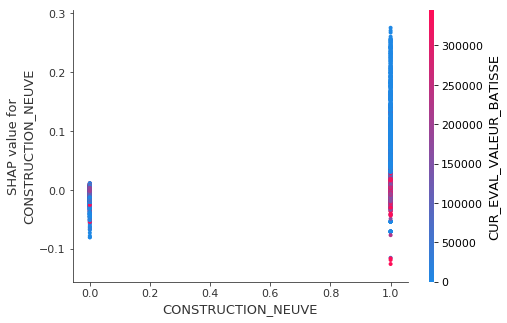

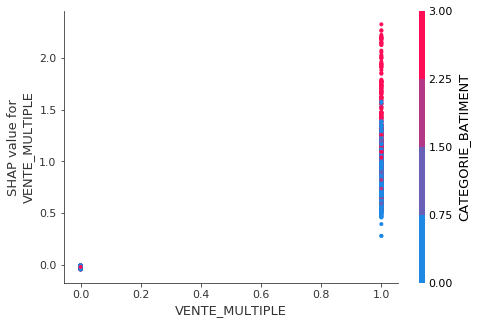

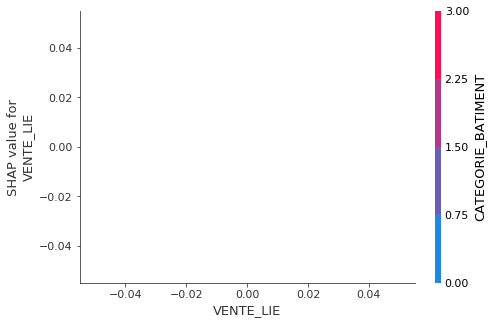

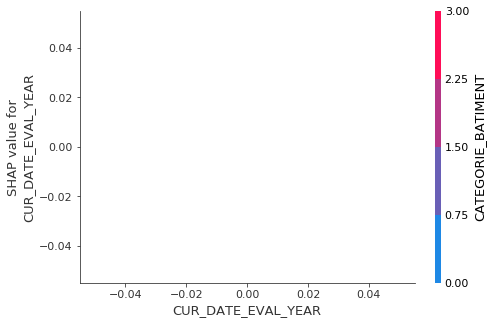

In [19]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)